In [1]:
import sumolib
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random

import torch
import torch_geometric
import torch_geometric.data as Data
import torch_geometric.utils as pyg_utils

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import json
import sys



In [3]:
array = np.array([1,2,3])
print(array)

[1 2 3]


First let's read in the graph file and see if it works properly

## Data handling

In [3]:
#Function to plot the graph
def plot_graph(G):
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=False, node_size=1)
    plt.show()
def evaluate_all_graphs(model, prepared_training_data, prepared_test_data, edges_to_hide, criterion):
    total_loss = 0
    for i in range(len(prepared_training_data)):
        output = model(prepared_training_data[i].edge_attr, prepared_training_data[i].edge_index)
        loss = criterion(output[edges_to_hide], prepared_test_data[i].edge_attr[edges_to_hide])
        total_loss += loss
    return total_loss/len(prepared_training_data)


Graph = read_sumo_net('s_gyor.net.xml')


Data(x=[413, 2], edge_index=[2, 504], edge_attr=[504, 1])


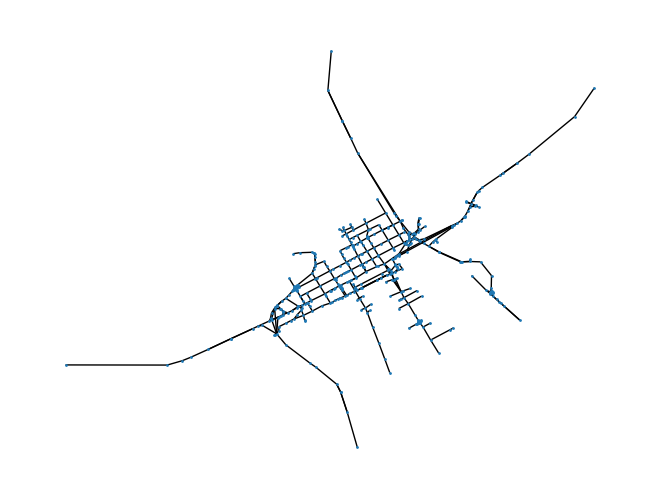

In [4]:
G1 = read_sumo_net('s_gyor.net.xml')
G2 = add_edge_features_from_xml(G1,'gyor_forg_15_min.xml',"0.00")
pyg_data = nx_to_pyg(G2)
print(pyg_data)
plot_graph(G1)

## Initialization of the model

In [62]:
G2 = add_edge_features_from_xml(G1,'gyor_forg_15_min.xml',"10800.00")
with open('edges_to_hide.json', 'r') as file:
    edges_to_hide = json.load(file)
data = torch.load('data.pth')

prepared_training_data, prepared_test_data, summa = data_preparation(data, edges_to_hide)
print(summa)


# Define the model
edge_dim = 1  # Number of edge features
hidden_dim1 = 32
hidden_dim2 = 128
hidden_dim3 = 64
hidden_dim4 = 32
hidden_dim5 = 32
hidden_dim6 = 32
hidden_dim7 = 32
hidden_dim8 = 32

model = GNN(edge_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, hidden_dim8)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

num_epochs = 10000
losses = []
total_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    i = random.randint(0, len(prepared_test_data)-1)
    """ if epoch % 100 == 0:
        i = random.randint(0, len(prepared_test_data)-1) """
    # Forward pass
    output = model(prepared_training_data[i].edge_attr, prepared_training_data[i].edge_index)
    
    # Compute loss using the predicted features and the input features of the hidden edges
    loss = criterion(output[edges_to_hide], prepared_test_data[i].edge_attr[edges_to_hide])
    losses.append(float(loss))
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        total_loss = evaluate_all_graphs(model, prepared_training_data, prepared_test_data, edges_to_hide, criterion)
        total_losses.append(float(total_loss))
    print(sys.getsizeof(losses))
    print(sys.getsizeof(total_losses))


with open('total_losses.json', 'w') as file:
    json.dump(total_losses, file)
with open('losses.json', 'w') as file:
    json.dump(losses, file)

tensor(0.0980)
Epoch 1, Loss: 0.08467025309801102
88
88
88
88
88
88
88
88
120
88
120
88
120
88
120
88
184
88
184
88
184
88
184
88
184
88
184
88
184
88
184
88
248
88
248
88
248
88
248
88
248
88
248
88
248
88
248
88
312
88
312
88
312
88
312
88
312
88
312
88
312
88
312
88
376
88
376
88
376
88
376
88
376
88
376
88
376
88
376
88
472
88
472
88
472
88
472
88
472
88
472
88
472
88
472
88
472
88
472
88
472
88
472
88
568
88
568
88
568
88
568
88
568
88
568
88
568
88
568
88
568
88
568
88
568
88
568
88
664
88
664
88
664
88
664
88
664
88
664
88
664
88
664
88
664
88
664
88
664
88
664
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
920
88
920
88
920
88
920
88
920
88
920
88
920
88
920
88
Epoch 101, Loss: 0.05905088409781456
920
88
920
88
920
88
920
88
920
88
920
88
920
88
920
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1

1358


In [65]:
torch.save(model.state_dict(), 'gnn_model_ces.pth')
#cep : change every step
layers = [model.conv1, model.conv2, model.conv3, model.conv4, model.conv5, model.conv6, model.conv7, model.conv8]
edge_dims = []
for layer in layers:
    edge_dims.append(layer.in_channels)
edge_dims.append(model.linear.in_features)
with open('dimensions.json','w') as file:
    json.dump(edge_dims, file)


## Loading the model
Once we trained it nd saved it, this is how we can load it

In [66]:
with open('edges_to_hide.json', 'r') as file:
    edges_to_hide = json.load(file)
data = torch.load('data.pth')

prepared_training_data, prepared_test_data, summa = data_preparation(data, edges_to_hide)

with open('dimensions.json', 'r') as file:
    edge_dims = json.load(file)

model2 = GNN(edge_dims[0], edge_dims[1], edge_dims[2], edge_dims[3], edge_dims[4], edge_dims[5], edge_dims[6], edge_dims[7], edge_dims[8])
model2.load_state_dict(torch.load('gnn_model_ces.pth'))


<All keys matched successfully>

In [13]:
def make_an_estimation(edges_to_hide, model, data_training):
    edge_features = data_training.edge_attr
    max_value = edge_features.max()
    normalized_edge_features = edge_features / max_value
    data_training.edge_attr = normalized_edge_features
    output = model(data_training.edge_attr, data_training.edge_index)
    loss = criterion(output[edges_to_hide], data_testing.edge_attr[edges_to_hide])
    return loss, output

G3 = add_edge_features_from_xml(G1,'gyor_forg_15_min.xml',"9000.00")
data_training2 = nx_to_pyg(G3)
make_an_estimation(edges_to_hide, model, data_training2)

NameError: name 'data_testing' is not defined

## Data visualization

In [67]:
def losses_epoch_plot(losses, save, save_name):
    fig = plt.figure()
    epochs = np.linspace(start=0, stop=np.size(losses), num=np.size(losses))
    plt.scatter(epochs,losses,c='red')
    plt.ylabel('Loss', fontsize=20)
    plt.xlabel('Epochs', fontsize=20)
    plt.grid(True,which='major',color='gray')
    plt.minorticks_on()
    plt.tick_params(axis='both', which='both', direction= 'in')
    plt.ylim([0,0.2])
    fig.set_size_inches(14,7.5)
    if save:
        plt.savefig(save_name)



def enhanced_histogram(data, bins=30, save=False, save_name='histogram.png'):
    fig = plt.figure()
    plt.hist(data, bins=bins, color='blue', edgecolor='black')
    plt.ylabel('Frequency', fontsize=20)
    plt.xlabel('Difference', fontsize=20)  # Changed to 'Difference' to reflect the data
    plt.grid(True, which='major', color='gray', linestyle='--', linewidth=0.7)
    plt.minorticks_on()
    plt.grid(True, which='minor', color='lightgray', linestyle=':', linewidth=0.5)
    plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    fig.set_size_inches(14, 7.5)
    plt.title('Histogram of Differences', fontsize=22)  # Changed title to reflect the data

    if save:
        plt.savefig(save_name)
    plt.show()



352
tensor([0.6543])
tensor([0.0483])
tensor([0.9108])
tensor([0.])
tensor([0.1041])
tensor([0.0335])
tensor([0.])
tensor([0.0074])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.4201])
tensor([0.])
tensor([0.3346])
tensor([0.])
tensor([0.7175])
tensor([0.0595])
tensor([0.2268])
tensor([0.1413])
tensor([0.5762])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.2007])
tensor([0.0297])
tensor([0.3197])
tensor([0.3420])
tensor([0.0706])
tensor([0.7323])
tensor([0.5651])
tensor([0.0409])
tensor([0.])
tensor([0.0372])
tensor([0.7472])
tensor([0.5390])
tensor([0.6171])
tensor([0.0372])
tensor([0.0260])
tensor([0.0297])
tensor([0.5799])
tensor([0.])
tensor([0.5242])
tensor([0.1896])
tensor([0.])
tensor([0.])
tensor([0.1784])
tensor([0.])
tensor([0.])
tensor([0.0855])
tensor([0.1152])
tensor([0.])
tensor([0.3123])
tensor([0.0074])
tensor([0.0967])
tensor([0.])
tensor([0.])
tensor([0.5316])
tensor([0.])
tensor([0.6989])
tensor([0.0483])
tensor([0.0595])
tensor([0.5688])
tensor([0.3048])
tenso

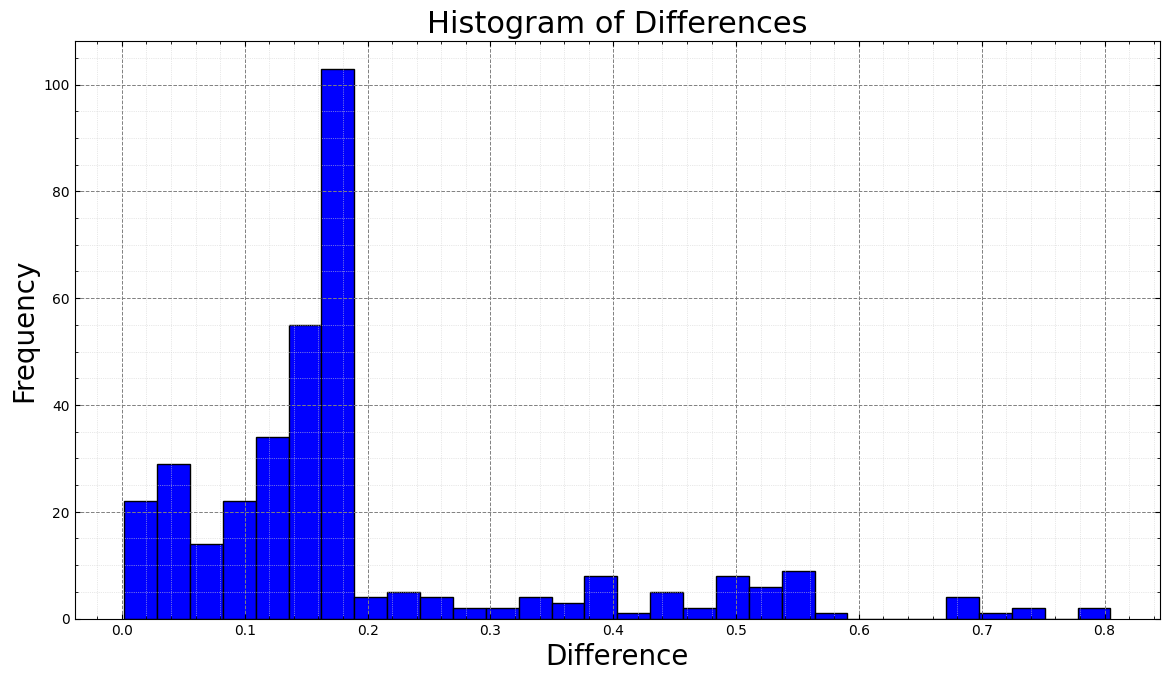

In [68]:
#losses_epoch_plot(losses,False,'asd')

N = 352
print(N)
difference = np.zeros(N)
output = model2(prepared_training_data[3].edge_attr, prepared_training_data[3].edge_index)
for j in range(N):
    if output[edges_to_hide][j]<0:
        output[edges_to_hide][j] = 0
    difference[j] = float(abs(output[edges_to_hide][j] - prepared_test_data[3].edge_attr[edges_to_hide][j]))
    print(prepared_test_data[3].edge_attr[edges_to_hide][j])
    #print(output[edges_to_hide][i])
enhanced_histogram(difference, bins=30, save=False, save_name='enhanced_histogram.png')


352
[1, 2, 3, 4, 6, 7, 8, 9, 11, 13, 14, 19, 20, 21, 22, 23, 25, 26, 27, 29, 32, 33, 35, 36, 38, 39, 40, 41, 43, 44, 46, 47, 48, 50, 52, 53, 55, 56, 57, 59, 60, 61, 62, 66, 67, 68, 69, 70, 71, 72, 74, 75, 78, 79, 80, 82, 84, 85, 86, 87, 90, 91, 93, 94, 95, 96, 98, 99, 100, 101, 103, 104, 105, 107, 108, 111, 112, 113, 116, 117, 119, 121, 122, 123, 126, 127, 128, 129, 131, 132, 133, 134, 136, 138, 139, 140, 143, 144, 146, 147, 149, 150, 153, 154, 155, 156, 158, 160, 163, 164, 166, 167, 168, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 208, 209, 211, 213, 216, 217, 218, 219, 220, 222, 225, 226, 227, 229, 230, 231, 233, 234, 235, 236, 237, 238, 241, 242, 243, 244, 246, 247, 248, 249, 252, 254, 256, 257, 258, 259, 261, 262, 264, 265, 267, 268, 270, 274, 275, 276, 278, 279, 280, 281, 285, 287, 289, 290, 291, 292, 293, 295, 298, 300, 301, 303, 304, 305, 306, 307, 309, 310, 312, 313, 315, 316, 317, 318, 319, 3

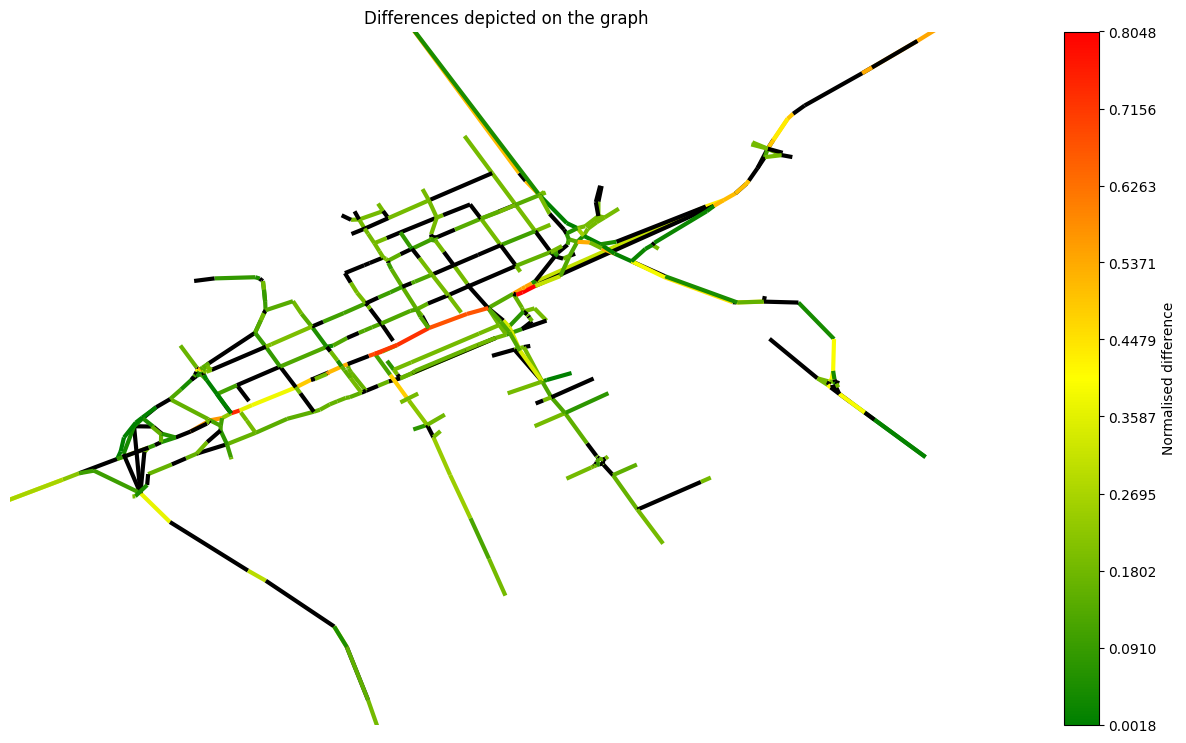

In [69]:
def plot_graph_weight(G,model_output,hidenedges):

    plt.figure(figsize=(16,9))
    """ fig, ax = plt.subplots(dpi=100)
    mycax=ax.inset_axes[0.95, 0.1, 0.05, 0.8] """ 
    """ cax = plt.axes((0.85, 0.1, 0.075, 0.8)) """
    
    pos = nx.get_node_attributes(G, 'pos')
    N = 352
    print(N)
    edges_to_hide_sort=hidenedges
    edges_to_hide_sort.sort()
    difference = np.zeros(N)
    print(edges_to_hide_sort)
    for i in range(N):
        if model_output[edges_to_hide_sort][i]<0:
            model_output[edges_to_hide_sort][i] = 0
        difference[i] = float(abs(model_output[edges_to_hide_sort][i] - prepared_test_data[3].edge_attr[edges_to_hide_sort][i]))

    maxdiff = max(difference)
    mindiff = min(difference)
    maxdiff_int=int(maxdiff)
    print(maxdiff)
    mindiff_int=int(mindiff)
    print(mindiff_int)
    
    c = np.arange(10, maxdiff_int + 1)


    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "yellow", "red"])
     
    colors = [cmap(c/maxdiff) for c in difference]
    

    edge_colors = {edge: 'black' for edge in G.edges()}


    edges_to_color_edges = []
    edges=list(G2.edges())
    edges_to_color_by_id=[]

    for i in edges_to_hide:
        edges_to_color_edges.append(edges[i])
    for i in edges_to_color_edges:
        edges_to_color_by_id.append(G2.edges[i]['edge_id'])

    colorindexiter=0
    for edge in G.edges():
        edge_id = G.edges[edge]['edge_id']


        if edge_id in edges_to_color_by_id:

            edge_colors[edge] = colors[colorindexiter]
            colorindexiter+=1

    plt.axis([250, 3500, -500, 2500])
    nx.set_edge_attributes(G, edge_colors, 'color')

    edge_color_values = [G[u][v]['color'] for u, v in G.edges()]
    options = {
        

        "width": 3,
        "edge_cmap": plt.cm.Blues,
        "with_labels": False,
    }
    nx.draw(G, pos, **options, edge_color=edge_color_values, node_size=0) 
    
    norm = matplotlib.colors.Normalize(vmin=mindiff, vmax=maxdiff) 
  
    # creating ScalarMappable 
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
    sm.set_array([]) 
    
    plt.colorbar(sm, ax=plt.gca(),ticks=np.linspace(mindiff, maxdiff,10),label="Normalised difference") 
    plt.title('Differences depicted on the graph')
    plt.show()
    
plot_graph_weight(G2,output,edges_to_hide) 

352
[1, 2, 3, 4, 6, 7, 8, 9, 11, 13, 14, 19, 20, 21, 22, 23, 25, 26, 27, 29, 32, 33, 35, 36, 38, 39, 40, 41, 43, 44, 46, 47, 48, 50, 52, 53, 55, 56, 57, 59, 60, 61, 62, 66, 67, 68, 69, 70, 71, 72, 74, 75, 78, 79, 80, 82, 84, 85, 86, 87, 90, 91, 93, 94, 95, 96, 98, 99, 100, 101, 103, 104, 105, 107, 108, 111, 112, 113, 116, 117, 119, 121, 122, 123, 126, 127, 128, 129, 131, 132, 133, 134, 136, 138, 139, 140, 143, 144, 146, 147, 149, 150, 153, 154, 155, 156, 158, 160, 163, 164, 166, 167, 168, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 208, 209, 211, 213, 216, 217, 218, 219, 220, 222, 225, 226, 227, 229, 230, 231, 233, 234, 235, 236, 237, 238, 241, 242, 243, 244, 246, 247, 248, 249, 252, 254, 256, 257, 258, 259, 261, 262, 264, 265, 267, 268, 270, 274, 275, 276, 278, 279, 280, 281, 285, 287, 289, 290, 291, 292, 293, 295, 298, 300, 301, 303, 304, 305, 306, 307, 309, 310, 312, 313, 315, 316, 317, 318, 319, 3

C:\Users\nemes\AppData\Local\Temp\ipykernel_17424\145549436.py:18: RuntimeWarning: invalid value encountered in sqrt
  difference[i] = float(abs(model_output[edges_to_hide_sort][i] - prepared_test_data[3].edge_attr[edges_to_hide_sort][i])*np.sqrt(2)/np.sqrt(float(model_output[edges_to_hide_sort][i] + prepared_test_data[3].edge_attr[edges_to_hide_sort][i])))


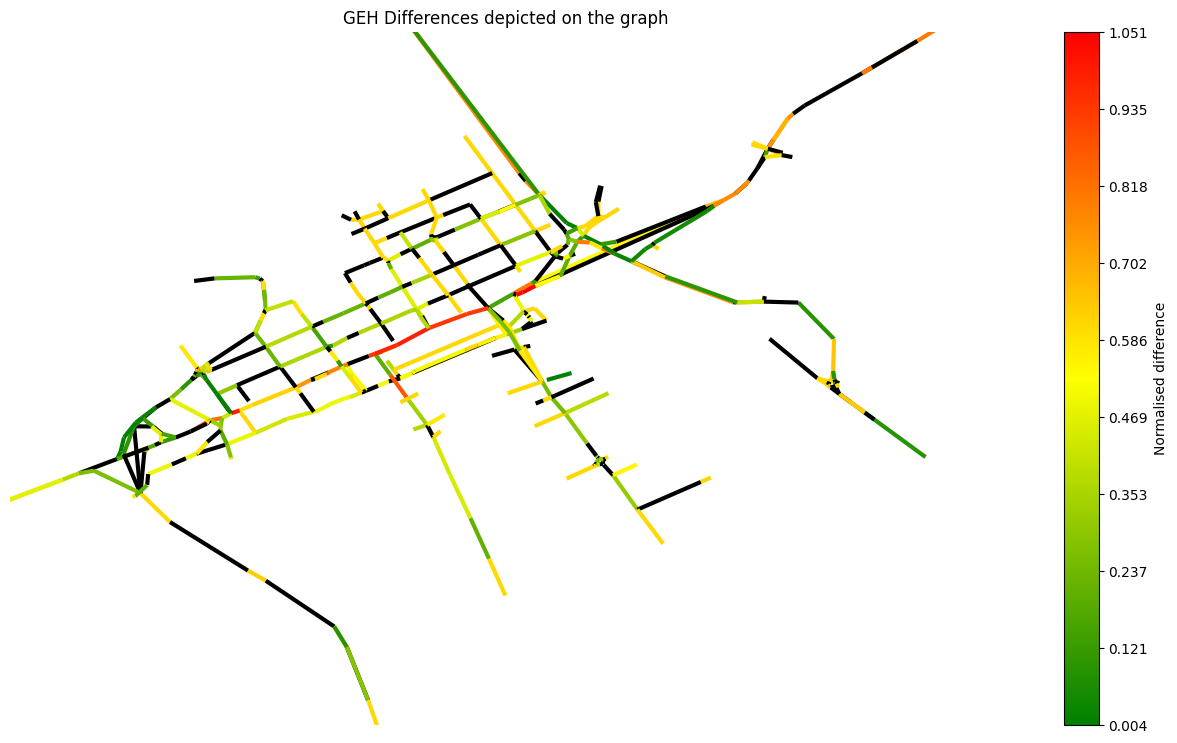

In [71]:
def plot_graph_weight_GEH(G,model_output,hidenedges):

    plt.figure(figsize=(16,9))
    """ fig, ax = plt.subplots(dpi=100)
    mycax=ax.inset_axes[0.95, 0.1, 0.05, 0.8] """ 
    """ cax = plt.axes((0.85, 0.1, 0.075, 0.8)) """
    
    pos = nx.get_node_attributes(G, 'pos')
    N = 352
    print(N)
    edges_to_hide_sort=hidenedges
    edges_to_hide_sort.sort()
    difference = np.zeros(N)
    print(edges_to_hide_sort)
    for i in range(N):
        if model_output[edges_to_hide_sort][i]<0:
            model_output[edges_to_hide_sort][i] = 0
        difference[i] = float(abs(model_output[edges_to_hide_sort][i] - prepared_test_data[3].edge_attr[edges_to_hide_sort][i])*np.sqrt(2)/np.sqrt(float(model_output[edges_to_hide_sort][i] + prepared_test_data[3].edge_attr[edges_to_hide_sort][i])))

    maxdiff = max(difference)
    mindiff = min(difference)
    maxdiff_int=int(maxdiff)
    print(maxdiff)
    mindiff_int=int(mindiff)
    print(mindiff_int)
    
    c = np.arange(10, maxdiff_int + 1)


    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "yellow", "red"])
     
    colors = [cmap(c/maxdiff) for c in difference]
    

    edge_colors = {edge: 'black' for edge in G.edges()}


    edges_to_color_edges = []
    edges=list(G2.edges())
    edges_to_color_by_id=[]

    for i in edges_to_hide:
        edges_to_color_edges.append(edges[i])
    for i in edges_to_color_edges:
        edges_to_color_by_id.append(G2.edges[i]['edge_id'])

    colorindexiter=0
    for edge in G.edges():
        edge_id = G.edges[edge]['edge_id']


        if edge_id in edges_to_color_by_id:

            edge_colors[edge] = colors[colorindexiter]
            colorindexiter+=1

    plt.axis([250, 3500, -500, 2500])
    nx.set_edge_attributes(G, edge_colors, 'color')

    edge_color_values = [G[u][v]['color'] for u, v in G.edges()]
    options = {
        

        "width": 3,
        "edge_cmap": plt.cm.Blues,
        "with_labels": False,
    }
    nx.draw(G, pos, **options, edge_color=edge_color_values, node_size=0) 
    
    norm = matplotlib.colors.Normalize(vmin=mindiff, vmax=maxdiff) 
  
    # creating ScalarMappable 
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
    sm.set_array([]) 
    
    plt.colorbar(sm, ax=plt.gca(),ticks=np.linspace(mindiff, maxdiff,10),label="Normalised difference") 
    plt.title('GEH Differences depicted on the graph')
    plt.show()
    
plot_graph_weight_GEH(G2,output,edges_to_hide) 